# Figure 10 ENSO -  Cresswell-Clay et. al. 2025

NOTE: YOU DON'T NEED TO RUN LOAD DATA IF YOU HAVE CACHED REGRESSION VALUES

Shows:
- a) NINO3.4 timeseries
- b) power spectrum, 
- c) patterns of SST regression coefficients with NINO3.4
- d) patterns of OLR regression coefficients with NINO3.4


Data Info: 

Forecasts with OLR: 
- atmos forecast: /home/disk/brass/nacc/forecasts/hpx32_coupled-dlwp_olr+hpx32_coupled-dlom_olr/atmos_hpx32_coupled-dlwp_olr+hpx32_coupled-dlom_olr_100yr.nc
- ocean forecast: /home/disk/brass/nacc/forecasts/hpx32_coupled-dlwp_olr+hpx32_coupled-dlom_olr/ocean_hpx32_coupled-dlwp_olr+hpx32_coupled-dlom_olr_100yr.nc
- lat-lon SST forecast:  /home/disk/brass/nacc/forecasts/hpx32_coupled-dlwp_olr+hpx32_coupled-dlom_olr/ocean_hpx32_coupled-dlwp_olr+hpx32_coupled-dlom_olr_100yr_sst_ll.nc
- monthly Nino3.4 anomalies: /home/disk/brume/nacc/WeeklyNotebooks/2024.02.26/dlesm-olr/dlesm-olr_100yr_sst_monthly_averages.nc

HPX64 Coupled Forecast:
- /home/disk/rhodium/nacc/forecasts/hpx64_coupled-dlwp-olr_seed0+hpx64_coupled-dlom-olr_unet_dil-112_double_restart

ERA5 Record: 
- 1deg SST data: /home/disk/rhodium/dlwp/data/era5/1deg/era5_1950-2022_3h_1deg_sst.nc
- 1deg OLR data: Refer to olr_remap.ipynb

In [1]:
import os
import numpy as np
import xarray as xr
import xskillscore as xscore
import xcdat as xc # version 0.5.0
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature

from scipy.io import netcdf
from scipy.io import loadmat
import pandas as pd
import scipy.signal as sig
import xarray as xr
import netCDF4 as nc
import warnings
from scipy.signal import detrend, welch
from scipy.stats import f as f_dist
from dask.diagnostics import ProgressBar

from scipy.stats import linregress
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [2]:
cdict2 = [
    (36,   0, 216),
    (24,  28, 247),
    (40,  87, 255),
    (61, 135, 255),
    (86, 176, 255),
    (117, 211, 255),
    (153, 234, 255),
    (188, 249, 255),
    (234, 255, 255),
    (255, 255, 234),
    (255, 241, 188),
    (255, 214, 153),
    (255, 172, 117),
    (255, 120,  86),
    (255,  61,  61),
    (247,  39,  53),
    (216,  21,  47),
    (165,   0,  33),
]
# Convert to 0 to 1
cdict2 = [(r/255, g/255, b/255) for i, (r, g, b) in enumerate(cdict2)]
mpl.colormaps.register(LinearSegmentedColormap.from_list('BWYR', cdict2))


# Utils

## Utils - Regressions Maps

In [3]:
def convert_step2time(ds):
    time = ds.coords["step"].values + ds.coords["time"].values
    ds["step"] = time
    ds = ds.squeeze()
    ds = ds.drop("time")
    ds =  ds.rename({"step": "time"})
    return ds 

def calculate_spatial_anomalies(ds: xr.Dataset, var: str, reference_period=None):
    """
    Calculate spatial anomalies (using entire timeseries as climatology)
    """
    # Add bounds
    ds = ds.bounds.add_bounds("T")
    ds['time'].encoding['calendar'] = 'standard'
    ds_anoms = ds.temporal.departures(data_var=var, freq="month", reference_period=reference_period)
    return ds_anoms

def calculate_spatial_climatology(ds: xr.Dataset, var: str, reference_period=None):
    """
    Calculate spatial anomalies (using entire timeseries as climatology)
    """
    # Add bounds
    ds = ds.bounds.add_bounds("T")
    ds['time'].encoding['calendar'] = 'standard'
    ds_anoms = ds.temporal.climatology(data_var=var, freq="month")
    return ds_anoms


def resample_daily2monthly(ds):
    """
    Resample daily data to monthly
    """
    return ds.resample(time="1M").mean()


def calculate_nino34_index(ds):
    """
    Calculate Nino3.4 index spatial averages
    Return raw and standardized timeseries
    """
    ds = ds.bounds.add_bounds("X")
    ds = ds.bounds.add_bounds("Y")
    # 5S -5N and 170W (360-170) and 120W (360-120)
    nino34 = ds.sel(lat=slice(5, -5), lon=slice(190, 240)).spatial.average("sst")
    nino34_std = (nino34 - nino34.mean()) / nino34.std()
    return nino34, nino34_std

def regress_nino34(ds, nino34):
    """
    Regress Nino3.4 index onto ds and return regression coefficients
    """
    # Rechunk on time
    ds = ds.chunk({"time": -1})
    nino34 = nino34.chunk({"time": -1})
    # get regression coefficients for linear regression
    reg_coeffs =  xscore.linslope(nino34, ds, dim="time", skipna=False, keep_attrs=True)
    # get pvalues
    pvalues = xscore.pearson_r_p_value(nino34, ds, dim="time", skipna=False, keep_attrs=True)
    return reg_coeffs, pvalues

## Utils - Timeseries

Saving plot to ./100yr_hpx64_6month_rolling_fcst_anomaly_ts


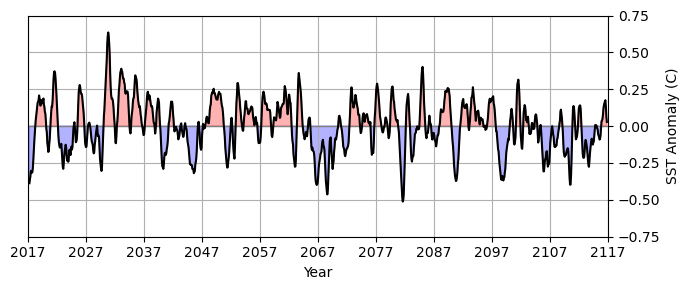

In [4]:
def rolling_6(ts):

    # Apply the filter to the time series
    return pd.DataFrame(ts).rolling(window=6, center=True).mean().values.flatten()

def plot_enso_time_series(
    output_directory,
    cache_dir,
    prefix,
    fcst_plotting_range=slice('2066-01-01','2116-12-31'),
    anomaly_range_fcst=(-3.5,3.5),
    plot_file='enso_suite',
    filter_function=rolling_6,
):
    
    # resample data to monthly, cache
    if not os.path.exists(f'{cache_dir}/{prefix}_fcst_monthly_anomalies_sst.nc'):
        averages_cache_file = f'{cache_dir}/{prefix}_fcst_monthly_averages_sst.nc'
        print(f'Loading cached averages from {averages_cache_file}')
        fcst = xr.open_dataarray(averages_cache_file, chunks="auto")

        # change dimension of forecast to be the same as climo
        fcst['month'] = fcst['step'].dt.month
        fcst_climo = fcst.groupby('month').mean().squeeze()

        # calculate monthly anomalies versus era5 climo and versus forecast climo
        anom_fcst = (fcst.groupby('month') - fcst_climo).mean(dim=['lat','lon']).squeeze()

        #resample to desired date range
        anom_fcst = anom_fcst.sel(step=fcst_plotting_range)
        # Save to cache
        anom_fcst.to_netcdf(f'{cache_dir}/{prefix}_fcst_monthly_anomalies_sst.nc')
    else:
        anom_fcst = xr.open_dataarray(f'{cache_dir}/{prefix}_fcst_monthly_anomalies_sst.nc', chunks="auto")

    ##################  CLIMO CYCLE PLOTTING ##################
    def setup_anomaly_plot(ax, xlim, ylim):
        # format y axis
        ax.set_ylabel('SST Anomaly (C)')
        if type(ylim)==np.ndarray:
            ax.set_yticks(ylim)
            ax.set_ylim(ylim[0],ylim[-1])
        else:
            ax.set_ylim(ylim)
        # format x axis
        ax.set_xlabel('Year')
        ax.set_xlim(pd.Timestamp(xlim.start), pd.Timestamp(xlim.stop))
        ax.grid()

        # reference lines and regions
        ax.axhline(y=0, color='grey', linestyle='-',linewidth=1)
        return ax
    
    ##################  FCST ANOMALY PLOTTING ##################

    # create figure, set up axes
    fig, ax = plt.subplots(figsize=(7,3))
    ax = setup_anomaly_plot(ax, xlim=fcst_plotting_range, ylim=anomaly_range_fcst)

    # Get time values and filtered values
    time_values = anom_fcst.step.values
    filtered_values = filter_function(anom_fcst.values)

    # plot anomalies, shade +-
    ax.fill_between(time_values, filtered_values, where=(filtered_values >= 0), interpolate=True, color='red', alpha=0.3)
    ax.fill_between(time_values, filtered_values, where=(filtered_values <= 0), interpolate=True, color='blue', alpha=0.3)
    ax.plot(time_values,filtered_values, color='k')

    # y axis labels on right side 
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

    # 10 year ticks
    ax.set_xticks([pd.Timestamp(t) for t in pd.date_range(start=fcst_plotting_range.start, end=fcst_plotting_range.stop, freq='10YS')])
    ax.set_xticklabels([str(t.year) for t in pd.date_range(start=fcst_plotting_range.start, end=fcst_plotting_range.stop, freq='10YS')])

    # tighten and save
    plot_file = f'{output_directory}/{prefix}_fcst_anomaly_ts'
    print(f'Saving plot to {plot_file}')
    fig.tight_layout()

    return filtered_values, time_values, fcst_plotting_range


filtered_values, time_values, fcst_plotting_range = plot_enso_time_series(
    output_directory='.',
    cache_dir='/home/disk/quicksilver2/zespinos/DLESyM/evaluation/cache',
    fcst_plotting_range = slice('2017-01-01','2117-01-01'),
    anomaly_range_fcst=np.arange(-.75,.76,.25),
    prefix='100yr_hpx64_6month_rolling',
    filter_function= rolling_6,
)

## Utils - Power Spectrum

Loading cached data from /home/disk/brume/nacc/DLESyM/evaluation/cache/forecast_monthly_nino34.nc and /home/disk/brume/nacc/DLESyM/evaluation/cache/reference_monthly_nino34.nc
Normalizing spectra to unit variance


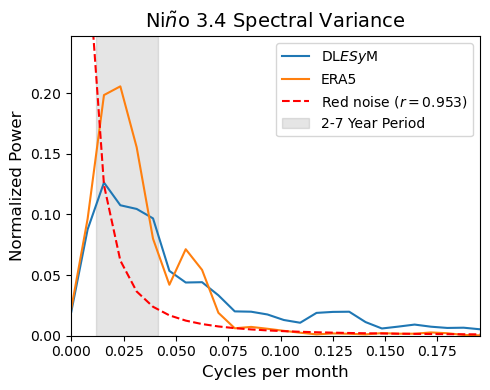

In [5]:
#  red noise spectrum
def red_noise_spectrum(r, f):
    return (1 - r**2) / (1 + r**2 - 2 * r * np.cos(2 * np.pi * f))

# Helper: compute lag-1 autocorrelation
def estimate_ar1(x):
    x = x - np.mean(x)
    return np.corrcoef(x[1:], x[:-1])[0, 1]

def _detrend_no_annual(data):

    # Remove monthly climatology
    monthly_clim = data.groupby("time.month").mean("time")
    da_anom = data.groupby("time.month") - monthly_clim

    # Detrend in time while keeping xarray structure
    da_detrended = xr.apply_ufunc(
        detrend,
        da_anom,
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        kwargs={"type": "linear", "axis": 0},
        vectorize=True,
        dask="parallelized",
        output_dtypes=[da_anom.dtype],
    )

    return da_detrended

def main(
        forecast_file: str,
        reference_file: str,
        cache_dir: str,
        window_size: int,
        spectral_fraction_plot: float,
        output_file: str,
        normalize_variance: bool = True,
        overwrite_cache: bool = False,
):
    cache_file_forecast = f"{cache_dir}/forecast_monthly_nino34.nc"
    cache_file_reference = f"{cache_dir}/reference_monthly_nino34.nc"

    # computationally bulky part of analysis, caching useful for quick re-runs
    if overwrite_cache or not (os.path.exists(cache_file_forecast) and \
                                os.path.exists(cache_file_reference)):
        
        print(f'Calculating Nino 3.4 region SST from forecast and reference data and caching to {cache_dir}')
        # open sst from forecast and reference
        forecast_sst = xr.open_dataset(forecast_file).sst
        reference_sst = xr.open_zarr(reference_file).inputs.sel(channel_in='sst')

        # get lat-lon encoding from reference
        lat = reference_sst.lat
        lon = reference_sst.lon

        # get face, height, width coordinates of Nino 3.4 region from lat, lon arrays
        nino_34_coords = lat >= -5.0
        nino_34_coords &= lat <= 5.0
        nino_34_coords &= lon >= 190.0
        nino_34_coords &= lon <= 240.0
        # clean up the coordinates
        nino_34_coords = nino_34_coords.squeeze().drop_vars(['lat', 'lon','level','channel_in'])

        # turn step dimension into valid time
        forecast_sst = forecast_sst.assign_coords(
            step=forecast_sst.step.values + forecast_sst.time.values
        ).squeeze().drop('time').rename({'step': 'time'})
        # index reference to match sampling of forecast
        reference_sst = reference_sst.sel(
            time=pd.date_range(reference_sst.time.values[0],
                            reference_sst.time.values[-1],
                            freq='2D')
        ).squeeze()

        # resample to monthly means
        forecast_sst = forecast_sst.resample(time='1M').mean()
        reference_sst = reference_sst.resample(time='1M').mean()

        # select Nino 3.4 region
        forecast_sst = forecast_sst.where(nino_34_coords, drop=True)
        reference_sst = reference_sst.where(nino_34_coords, drop=True)

        # enforce chunking for dask
        forecast_sst = forecast_sst.chunk({'time': 100, 'face': -1, 'height': -1, 'width': -1})
        reference_sst = reference_sst.chunk({'time': 100, 'face': -1, 'height': -1, 'width': -1})

        # final cleanup of reference sst dimensions
        reference_sst = reference_sst.squeeze().drop_vars(['channel_in', 'level', 'lat', 'lon'])

        # save to cache
        with ProgressBar():
            forecast_sst.to_netcdf(cache_file_forecast, mode='w', compute=True)
            reference_sst.to_netcdf(cache_file_reference, mode='w', compute=True)


    # load cached data
    print(f'Loading cached data from {cache_file_forecast} and {cache_file_reference}')
    forecast_nino34 = xr.open_dataarray(cache_file_forecast)
    reference_nino34 = xr.open_dataarray(cache_file_reference)

    # detrend and remove annual cycle
    forecast_nino34 = _detrend_no_annual(forecast_nino34.mean(dim=['face', 'height', 'width']))
    reference_nino34 = _detrend_no_annual(reference_nino34.mean(dim=['face', 'height', 'width']))
    
    # calculate spectra using Welch's method, we want 50% overlap 
    f, Pxx = sig.welch(forecast_nino34, nperseg=window_size, noverlap=window_size//2, detrend='linear') #  calculate spectra over same time period
    f, Pyy = sig.welch(reference_nino34, nperseg=window_size, noverlap=window_size//2, detrend='linear')

    if normalize_variance:
        # Normalize the spectra to have unit variance
        print("Normalizing spectra to unit variance")
        Pxx /= np.sum(Pxx)
        Pyy /= np.sum(Pyy)

    # Estimating AR1 correlation using our reference
    r_y = estimate_ar1(reference_nino34.values)
    P_red_y = red_noise_spectrum(r_y, f)
    # P_red_x = P_red_x * np.mean(Pxx)
    P_red_y = P_red_y * np.mean(Pyy)

    return Pxx, Pyy, f, P_red_y, r_y

spectral_fraction_plot = .4
normalize_variance = True

# spectral comparison of DLESYM and ERA5
Pxx, Pyy, f, P_red_y, r_y = main(
    forecast_file='/home/disk/rhodium/nacc/forecasts/hpx64_coupled-dlwp-olr_seed0+hpx64_coupled-dlom-olr_unet_dil-112_double_restart/ocean_hpx64_coupled-dlwp-olr_seed0+hpx64_coupled-dlom-olr_unet_dil-112_double_restart_100yearJanInit.nc',
    reference_file='/home/disk/rhodium/dlwp/data/HPX64/hpx64_1983-2017_3h_9varCoupledAtmos-sst.zarr',
    cache_dir='/home/disk/brume/nacc/DLESyM/evaluation/cache',
    window_size=128,
    spectral_fraction_plot=spectral_fraction_plot,
    output_file='enso_spectra_comparison',
    normalize_variance=normalize_variance,
    overwrite_cache=False,
)

def plot_power_spectra(ax, f, p, red, label):
    iend = int(len(f) * spectral_fraction_plot)
    ax.plot(f[0:iend], p[0:iend], label=label)
    if red is not None:
        ax.plot(f[0:iend], red[0:iend], '--', label=r'Red noise ($r=$'+str(np.around(r_y,3))+')', color='r')
    ax.set_xlabel('Cycles per month', fontsize=12)
    ax.set_ylabel('Normalized Power' if normalize_variance else 'Power', fontsize=12)
    return ax

fig, ax = plt.subplots(figsize=(5, 4))
ax = plot_power_spectra(ax, f, Pxx, None, f"DL$ESy$M")
ax = plot_power_spectra(ax, f, Pyy, P_red_y, f"ERA5")
ax.axvspan(0.04167,0.0119, color='k', alpha=.1, label='2-7 Year Period')
ax.set_title(r'Ni$\tilde{n}$o 3.4 Spectral Variance',fontsize=14)
ax.set_ylim(0, 1.2 * np.max([np.max(Pxx), np.max(Pyy)]))
ax.set_xlim(0, np.max(f[int(len(f) * spectral_fraction_plot)-1]))
ax.legend()
fig.tight_layout()

# Load Data

In [6]:
# Load lat-lon 100yr forecast data 
root_forecast = "/home/disk/rhodium/nacc/forecasts/hpx64_coupled-dlwp-olr_seed0+hpx64_coupled-dlom-olr_unet_dil-112_double_restart"
olr_forecast = xr.open_dataset(os.path.join(root_forecast, "atmos_hpx64_coupled-dlwp-olr_seed0+hpx64_coupled-dlom-olr_unet_dil-112_double_restart_100yearJanInit_olr_ll.nc"), chunks="auto")
sst_forecast = xr.open_dataset(os.path.join(root_forecast, "ocean_hpx64_coupled-dlwp-olr_seed0+hpx64_coupled-dlom-olr_unet_dil-112_double_restart_100yearJanInit_sst_ll.nc"), chunks="auto")
# Load lat-lon ERA5/Obs data
sst_obs = xr.open_dataset("/home/quicksilver2/zespinos/Data/ERA5/era5_1979-2022_daily_1deg_sst.nc", chunks="auto").rename({"latitude": "lat", "longitude": "lon"})
olr_obs = xr.open_dataset("/home/disk/quicksilver2/zespinos/olr_analysis/olr_ll_obs.nc", chunks="auto")

# Preprocess timestep data
sst_forecast = convert_step2time(sst_forecast)
olr_forecast = convert_step2time(olr_forecast)
olr_obs = convert_step2time(olr_obs)

In [7]:
# OBS
sst_obs_monthly = resample_daily2monthly(sst_obs)
sst_obs_anoms = calculate_spatial_anomalies(sst_obs_monthly, "sst")

olr_obs_monthly = resample_daily2monthly(olr_obs)
olr_obs_anoms = calculate_spatial_anomalies(olr_obs_monthly, "olr")

# FORECAST
sst_forecast_monthly = resample_daily2monthly(sst_forecast)
sst_forecast_anoms = calculate_spatial_anomalies(sst_forecast_monthly, "sst")

olr_forecast_monthly = resample_daily2monthly(olr_forecast)
olr_forecast_anoms = calculate_spatial_anomalies(olr_forecast_monthly, "olr")

# OBS
sst_obs_clim = calculate_spatial_climatology(sst_obs_monthly, "sst")
olr_obs_clim = calculate_spatial_climatology(olr_obs_monthly, "olr")

# FORECAST
sst_forecast_clim = calculate_spatial_climatology(sst_forecast_monthly, "sst")
olr_forecast_clim = calculate_spatial_climatology(olr_forecast_monthly, "olr")

nino34_obs, nino34_obs_std = calculate_nino34_index(sst_obs_anoms)
nino34_forecast, nino34_forecast_std = calculate_nino34_index(sst_forecast_anoms)

# Regression dX/dSST
sst_obs_regcoeff, sst_obs_pvals = regress_nino34(sst_obs_anoms["sst"], nino34_obs_std["sst"])
olr_obs_regcoeff, olr_obs_pvals = regress_nino34(olr_obs_anoms["olr"], nino34_obs_std["sst"].sel(time=olr_obs_anoms["time"]))

sst_forecast_regcoeff, sst_forecast_pvals = regress_nino34(sst_forecast_anoms["sst"], nino34_forecast_std["sst"].sel(time=sst_forecast_anoms["time"]))
olr_forecast_regcoeff, olr_forecast_pvals = regress_nino34(olr_forecast_anoms["olr"], nino34_forecast_std["sst"].sel(time=olr_forecast_anoms["time"]))

# Regression dX/dSST with non-noralized (non std)
sst_obs_regcoeff_nonstd, sst_obs_pvals_nonstd = regress_nino34(sst_obs_anoms["sst"], nino34_obs["sst"])
olr_obs_regcoeff_nonstd, olr_obs_pvals_nonstd = regress_nino34(olr_obs_anoms["olr"], nino34_obs["sst"].sel(time=olr_obs_anoms["time"]))

sst_forecast_regcoeff_nonstd, sst_forecast_pvals_nonstd = regress_nino34(sst_forecast_anoms["sst"], nino34_forecast["sst"].sel(time=sst_forecast_anoms["time"]))
olr_forecast_regcoeff_nonstd, olr_forecast_pvals_nonstd = regress_nino34(olr_forecast_anoms["olr"], nino34_forecast["sst"].sel(time=olr_forecast_anoms["time"]))


/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 44 times more chunks
  return self.array[key]
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 34 times more chunks
  return self.array[key]
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/xarray

In [ ]:
# remove nans from both datasets
sst_obs_regcoeff_nonans = sst_obs_regcoeff.values[~np.isnan(sst_forecast_regcoeff.values)]
sst_forecast_regcoeff_nonans = sst_forecast_regcoeff.values[~np.isnan(sst_forecast_regcoeff.values)]
sst_forecast_regcoeff_nonans = sst_forecast_regcoeff_nonans[~np.isnan(sst_obs_regcoeff_nonans)]
sst_obs_regcoeff_nonans = sst_obs_regcoeff_nonans[~np.isnan(sst_obs_regcoeff_nonans)]

reg = linregress(sst_forecast_regcoeff_nonans, sst_obs_regcoeff_nonans)
print(reg)
# HPX 32: LinregressResult(slope=2.0482641535541144, intercept=0.014846725802816851, rvalue=0.8797685913690066, pvalue=0.0, stderr=0.005334665933144795, intercept_stderr=0.00043064727745006307)
# HPX 64: LinregressResult(slope=2.781738034007513, intercept=-0.009829367388871458, rvalue=0.7557084295635056, pvalue=0.0, stderr=0.011619058937135341, intercept_stderr=0.0006141159878473234)

In [ ]:
# remove nans from both datasets
olr_obs_regcoeff_nonans = olr_obs_regcoeff.values[~np.isnan(olr_forecast_regcoeff.values)]
olr_forecast_regcoeff_nonans = olr_forecast_regcoeff.values[~np.isnan(olr_forecast_regcoeff.values)]
olr_forecast_regcoeff_nonans = olr_forecast_regcoeff_nonans[~np.isnan(olr_obs_regcoeff_nonans)]
olr_obs_regcoeff_nonans = olr_obs_regcoeff_nonans[~np.isnan(olr_obs_regcoeff_nonans)]

reg = linregress(olr_forecast_regcoeff_nonans, olr_obs_regcoeff_nonans)
print(reg)
# HPX 32: LinregressResult(slope=1.9907176986575448, intercept=0.17148424777429916, rvalue=0.7447280220483342, pvalue=0.0, stderr=0.0069886541575184735, intercept_stderr=0.00964725618927462)
# HPX 64: LinregressResult(slope=2.725805224606077, intercept=0.1673189335155475, rvalue=0.7660912445348389, pvalue=0.0, stderr=0.008959014838517737, intercept_stderr=0.009291304240704889)

# Plotting Utils

In [8]:
def _global_plot(ax, data, lon, lat, cmap, levels=50, left_title="", right_title=""):
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both", levels=levels,
    )

    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                 linewidth=1, color='gray', alpha=0.3, linestyle='--')
    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)
    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")

    ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())
    return img

In [9]:
def plot_regression_grid(
    datasets, infos, pvalues_list=None,
    nrows=1, ncols=1, figsize=(15, 12), cmap="BWYR"
):
    """
    Plot a top row with two time series plots (2/3 and 1/3 width),
    and a grid of regression maps below, each with its own colorbar.
    """
    assert len(datasets) == len(infos)
    if pvalues_list is not None:
        assert len(pvalues_list) == len(datasets)
    else:
        pvalues_list = [None] * len(datasets)

    fig = plt.figure(figsize=figsize)

    # === Top-Level GridSpec: 2 rows (1 top row, 1 for map grid) ===
    top_bottom_ratio = [1, 3]
    gs_master = GridSpec(2, 1, height_ratios=top_bottom_ratio, figure=fig, hspace=0.1, wspace=0.1)

    # === Top Row: split into 2/3 and 1/3 widths ===
    gs_top = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[0], width_ratios=[1.1, 1], wspace=0.2)
    ax_top_left = fig.add_subplot(gs_top[0])
    ax_top_right = fig.add_subplot(gs_top[1])

    ############ ENSO TIMESERIES ############ 
    ax_top_left.set_title("A", loc="left", fontweight="bold")
    ax_top_left.set_title(r"$Ni\tilde{n}o$3.4 DL$ESy$M", loc="right")

    ax_top_left.fill_between(time_values, filtered_values, where=(filtered_values >= 0), interpolate=True, color='red', alpha=0.3)
    ax_top_left.fill_between(time_values, filtered_values, where=(filtered_values <= 0), interpolate=True, color='blue', alpha=0.3)
    ax_top_left.plot(time_values,filtered_values, color='k')

    # y axis labels on right side 
    ax_top_left.yaxis.tick_right()
    ax_top_left.yaxis.set_label_position('right')

    # 10 year ticks
    ax_top_left.set_xticks([pd.Timestamp(t) for t in pd.date_range(start=fcst_plotting_range.start, end=fcst_plotting_range.stop, freq='10YS')])
    ax_top_left.set_xticklabels([str(t.year) for t in pd.date_range(start=fcst_plotting_range.start, end=fcst_plotting_range.stop, freq='10YS')])
    ax_top_left.grid()

    ############ ENSO SPECTRUM ############ 
    ax_top_right.set_title("B", loc="left", fontweight="bold")
    ax_top_right.set_title(r'$Ni\tilde{n}o$ 3.4 Spectral Variance', loc="right")

    def plot_power_spectra(ax, f, p, red, label):
        iend = int(len(f) * spectral_fraction_plot)
        ax.plot(f[0:iend], p[0:iend], label=label)
        if red is not None:
            ax.plot(f[0:iend], red[0:iend], '--', label=r'Red noise ($r=$'+str(np.around(r_y,3))+')', color='r')
        ax.set_xlabel('Cycles per month', fontsize=12)
        ax.set_ylabel('Normalized Power' if normalize_variance else 'Power', fontsize=12)
        return ax

    ax_top_right = plot_power_spectra(ax_top_right, f, Pxx, None, f"DL$ESy$M")
    ax_top_right = plot_power_spectra(ax_top_right, f, Pyy, P_red_y, f"ERA5")
    ax_top_right.axvspan(0.04167,0.0119, color='k', alpha=.1, label='2-7 Year Period')
    ax_top_right.set_ylim(0, 1.2 * np.max([np.max(Pxx), np.max(Pyy)]))
    ax_top_right.set_xlim(0, np.max(f[int(len(f) * spectral_fraction_plot)-1]))
    ax_top_right.legend()
    ax_top_right.grid()

    ############ ENSO REGRESSION MAPS ############ 
    # === Bottom Grid: map plots with colorbars ===
    gs_bottom = GridSpecFromSubplotSpec(nrows, ncols, subplot_spec=gs_master[1], hspace=0.3, wspace=0.1)

    for i, (data, info, pvals) in enumerate(zip(datasets, infos, pvalues_list)):
        row, col = divmod(i, ncols)
        ax = fig.add_subplot(gs_bottom[row, col], projection=ccrs.PlateCarree(central_longitude=180))

        # Plot the regression map
        img = _global_plot(
            ax,
            data=data,
            lat=data.lat,
            lon=data.lon,
            cmap=cmap,
            levels=info["levels"],
            left_title=info.get("left_title_1", ""),
            right_title=info.get("right_title_1", "")
        )

        # Optional: draw Nino3.4 bounding box
        def bound_region(ax, lons, lats, color):
            ax.plot(
                [lons[0], lons[0], lons[1], lons[1], lons[0]],
                [lats[0], lats[1], lats[1], lats[0], lats[0]],
                color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
            )

        bound_region(ax, lons=(190, 240), lats=(-5, 5), color="black")

        # Optional: stippling for significance
        if pvals is not None:
            ax.contourf(
                data.lon, data.lat, pvals,
                colors='none',
                levels=[0, .05],
                hatches=['..', ''],
                transform=ccrs.PlateCarree(),
            )

        # Add individual colorbar below each map
        cax = fig.add_axes([
            ax.get_position().x0,
            ax.get_position().y0 - 0.035,
            ax.get_position().width,
            0.015
        ])
        cbar = fig.colorbar(img, cax=cax, orientation="horizontal")
        cbar.ax.text(
            0.5, -2.5, info["cbar_label"],
            va="center", ha="center", rotation=0,
            transform=cbar.ax.transAxes, fontsize=12
        )

    # Save figure
    save_name = infos[0].get("save_name", "regression_grid")
    os.makedirs("figures", exist_ok=True)
    plt.savefig(os.path.join("figures", f"{save_name}.png"), dpi=400, bbox_inches='tight')
    plt.savefig(os.path.join("figures", f"{save_name}.pdf"), dpi=400, bbox_inches='tight')
    plt.show()


# Figure 10: Regression

In [10]:
sst_obs_regcoeff.name = "sst_obs_regcoeff"
olr_obs_regcoeff.name = "olr_obs_regcoeff"
sst_forecast_regcoeff.name = "sst_forecast_regcoeff"
olr_forecast_regcoeff.name = "olr_forecast_regcoeff"

sst_obs_pvals.name = "sst_obs_pvals"
olr_obs_pvals.name = "olr_obs_pvals"
sst_forecast_pvals.name = "sst_forecast_pvals"
olr_forecast_pvals.name = "olr_forecast_pvals"

In [11]:
datasets = [sst_obs_regcoeff, olr_obs_regcoeff, sst_forecast_regcoeff, olr_forecast_regcoeff]
pvalues = [sst_obs_pvals, olr_obs_pvals, sst_forecast_pvals, olr_forecast_pvals]

# Save each of these to a file
ROOT = "data/"
for data in datasets:
    if not os.path.exists(os.path.join(ROOT, f"{data.name}.nc")):
        print(f"Saving {data.name}.nc")
        data.to_netcdf(os.path.join(ROOT, f"{data.name}.nc"))
for pval in pvalues:
    if not os.path.exists(os.path.join(ROOT, f"{pval.name}.nc")):
        print(f"Saving {pval.name}.nc")
        pval.to_netcdf(os.path.join(ROOT, f"{pval.name}.nc"))

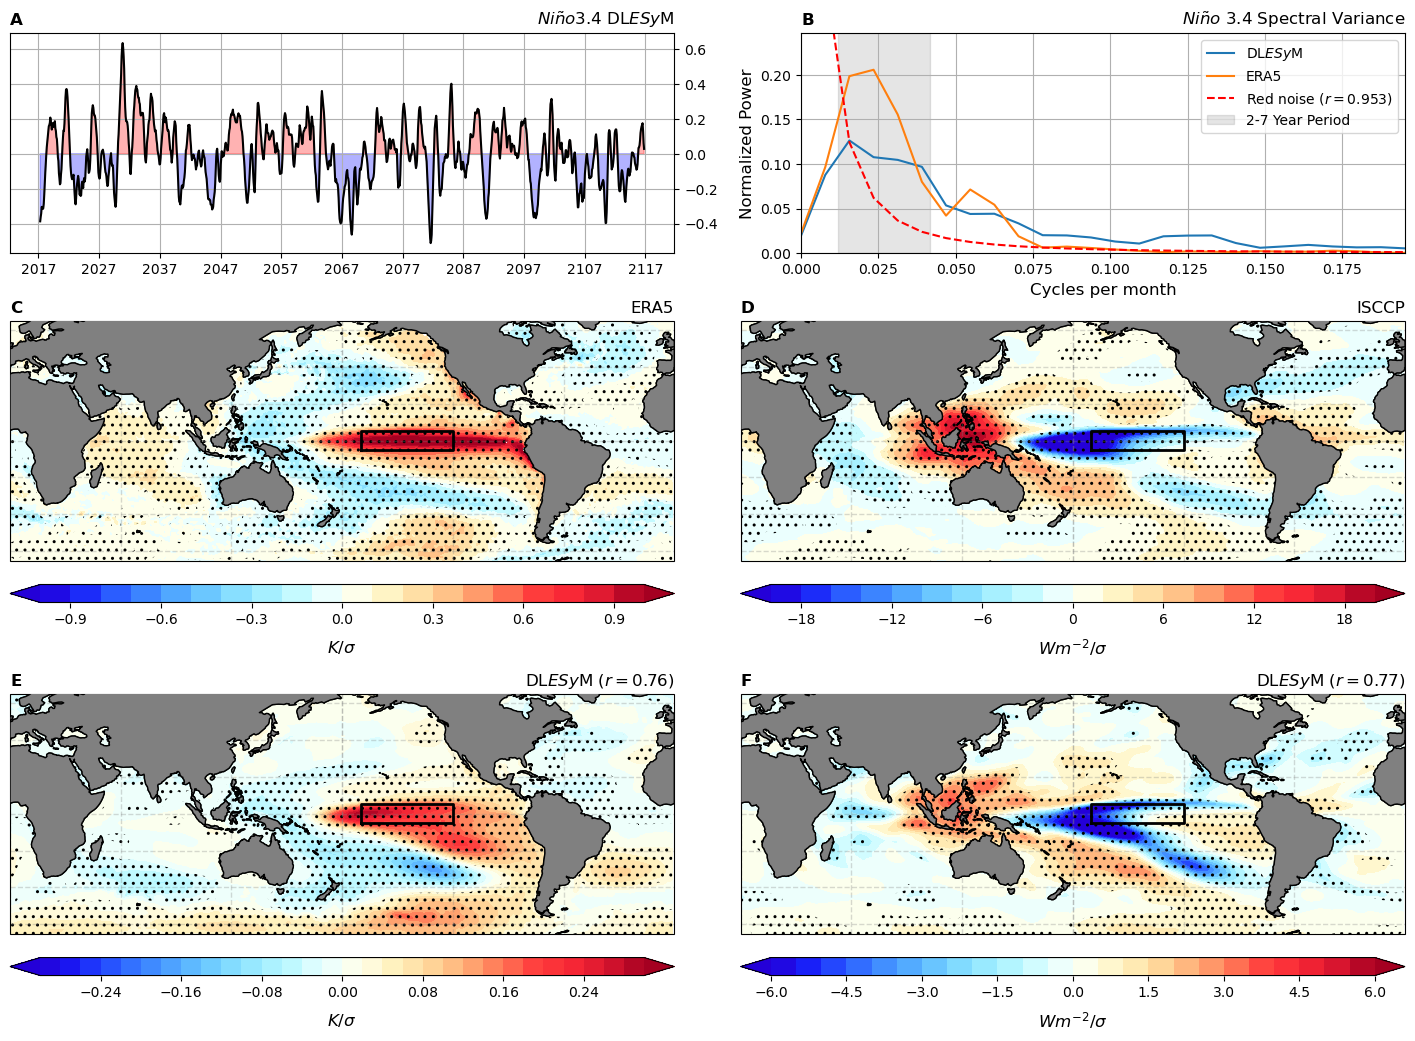

In [12]:
# now load them back in if needed
datasets = [
    xr.open_dataarray(os.path.join(ROOT, "sst_obs_regcoeff.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_obs_regcoeff.nc")),
    xr.open_dataarray(os.path.join(ROOT, "sst_forecast_regcoeff.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_forecast_regcoeff.nc"))
]
pvalues = [
    xr.open_dataarray(os.path.join(ROOT, "sst_obs_pvals.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_obs_pvals.nc")),
    xr.open_dataarray(os.path.join(ROOT, "sst_forecast_pvals.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_forecast_pvals.nc"))
]

infos = [
    {"save_name": "Figure_10_ENSO", 
     "left_title_1": "C", "right_title_1": "ERA5", "cbar_label": r"$K/\sigma$", "levels": np.arange(-1, 1.1, 0.1)},
    {"left_title_1": "D", "right_title_1": "ISCCP", "cbar_label": r"$Wm^{-2}/\sigma$", "levels": np.arange(-20, 22, 2)},
    {"left_title_1": "E", "right_title_1": r"DL$ESy$M $(r=0.76)$", "cbar_label": r"$K/\sigma$", "levels": np.arange(-.3, .32, .02)},
    {"left_title_1": "F", "right_title_1": r"DL$ESy$M $(r=0.77)$", "cbar_label": r"$Wm^{-2}/\sigma$", "levels": np.arange(-6, 6.5, .5)},
]

plot_regression_grid(datasets, infos, pvalues_list=pvalues, nrows=2, ncols=2, figsize=(18, 12))

In [15]:
sst_obs_regcoeff_nonstd.name = "sst_obs_regcoeff_nonstd"
olr_obs_regcoeff_nonstd.name = "olr_obs_regcoeff_nonstd"
sst_forecast_regcoeff_nonstd.name = "sst_forecast_regcoeff_nonstd"
olr_forecast_regcoeff_nonstd.name = "olr_forecast_regcoeff_nonstd"

sst_obs_pvals_nonstd.name = "sst_obs_pvals_nonstd"
olr_obs_pvals_nonstd.name = "olr_obs_pvals_nonstd"
sst_forecast_pvals_nonstd.name = "sst_forecast_pvals_nonstd"
olr_forecast_pvals_nonstd.name = "olr_forecast_pvals_nonstd"

In [16]:
datasets = [sst_obs_regcoeff_nonstd, olr_obs_regcoeff_nonstd, sst_forecast_regcoeff_nonstd, olr_forecast_regcoeff_nonstd]
pvalues = [sst_obs_pvals_nonstd, olr_obs_pvals_nonstd, sst_forecast_pvals_nonstd, olr_forecast_pvals_nonstd]

# Save each of these to a file
ROOT = "data/"
for data in datasets:
    if not os.path.exists(os.path.join(ROOT, f"{data.name}.nc")):
        print(f"Saving {data.name}.nc")
        data.to_netcdf(os.path.join(ROOT, f"{data.name}.nc"))
for pval in pvalues:
    if not os.path.exists(os.path.join(ROOT, f"{pval.name}.nc")):
        print(f"Saving {pval.name}.nc")
        pval.to_netcdf(os.path.join(ROOT, f"{pval.name}.nc"))

Saving sst_obs_regcoeff_nonstd.nc


/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cac

Saving olr_obs_regcoeff_nonstd.nc


/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Saving sst_forecast_regcoeff_nonstd.nc
Saving olr_forecast_regcoeff_nonstd.nc
Saving sst_obs_pvals_nonstd.nc


/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cac

Saving olr_obs_pvals_nonstd.nc


/home/disk/p/zespinos/miniforge3/envs/nsidc-prep/lib/python3.12/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


Saving sst_forecast_pvals_nonstd.nc
Saving olr_forecast_pvals_nonstd.nc


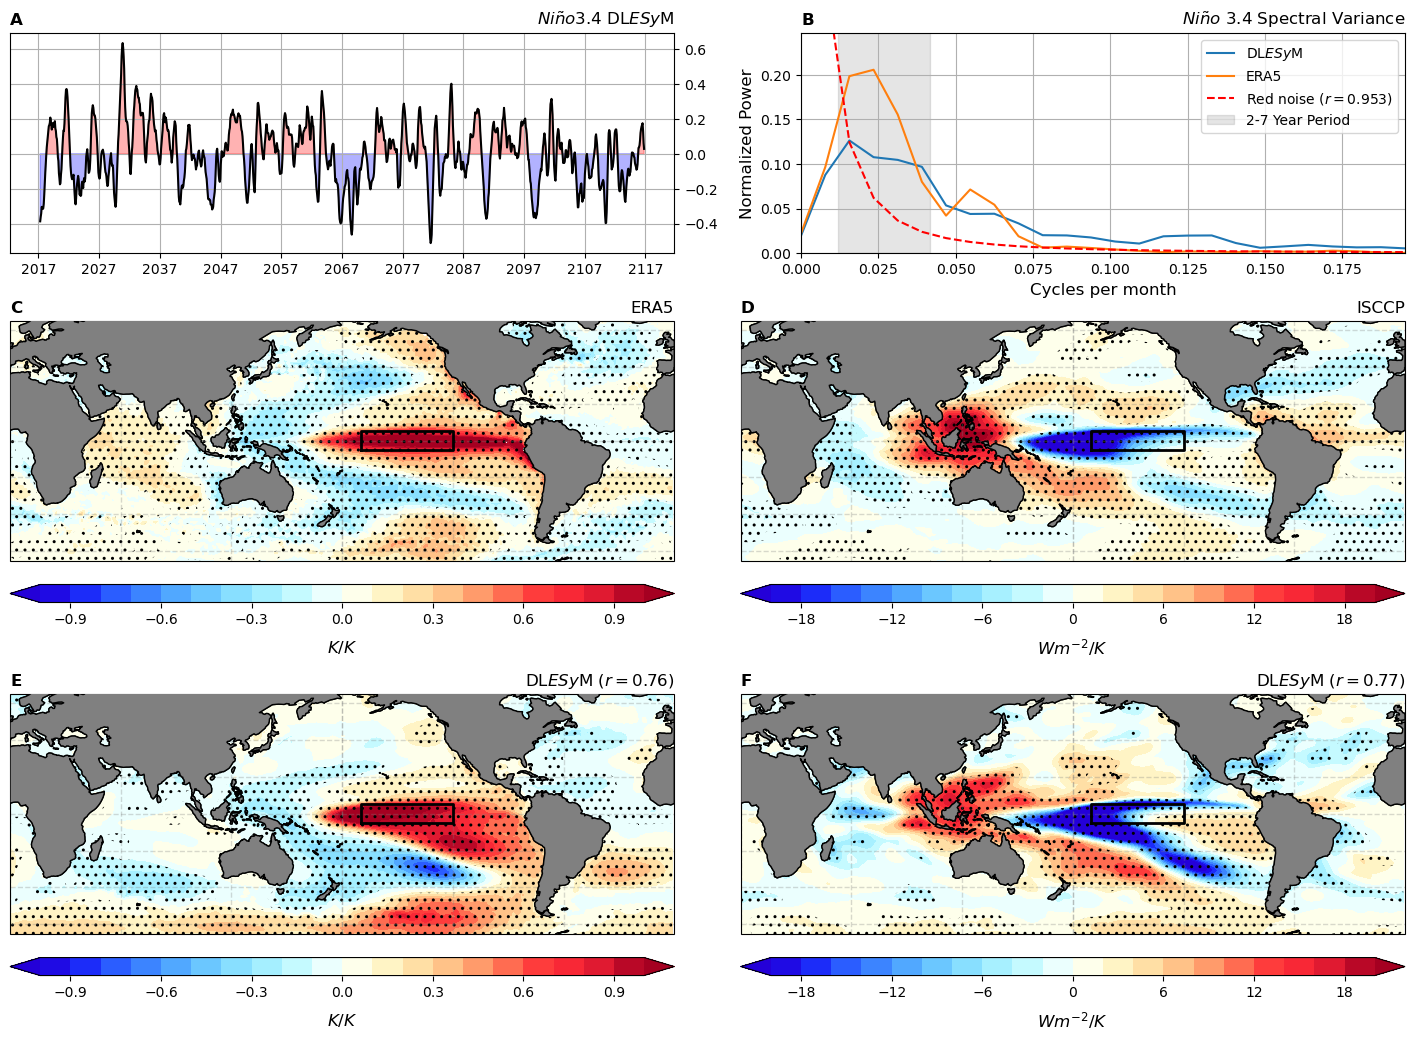

In [19]:
# now load them back in if needed
datasets = [
    xr.open_dataarray(os.path.join(ROOT, "sst_obs_regcoeff_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_obs_regcoeff_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "sst_forecast_regcoeff_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_forecast_regcoeff_nonstd.nc"))
]
pvalues = [
    xr.open_dataarray(os.path.join(ROOT, "sst_obs_pvals_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_obs_pvals_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "sst_forecast_pvals_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_forecast_pvals_nonstd.nc"))
]

infos = [
    {"save_name": "Figure_10_ENSO_non_normalized", 
     "left_title_1": "C", "right_title_1": "ERA5", "cbar_label": r"$K/K$", "levels": np.arange(-1, 1.1, 0.1)},
    {"left_title_1": "D", "right_title_1": "ISCCP", "cbar_label": r"$Wm^{-2}/K$", "levels": np.arange(-20, 22, 2)},
    {"left_title_1": "E", "right_title_1": r"DL$ESy$M $(r=0.76)$", "cbar_label": r"$K/K$", "levels": np.arange(-1, 1.1, 0.1)},
    {"left_title_1": "F", "right_title_1": r"DL$ESy$M $(r=0.77)$", "cbar_label": r"$Wm^{-2}/K$", "levels": np.arange(-20, 22, 2)},
]

plot_regression_grid(datasets, infos, pvalues_list=pvalues, nrows=2, ncols=2, figsize=(18, 12))

In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import cartopy.crs as ccrs

def plot_regression_grid(
    datasets, infos, pvalues_list=None,
    nrows=1, ncols=1, figsize=(15, 12), cmap="BWYR"
):
    """
    Plot a top row with two time series plots (2/3 and 1/3 width),
    and a grid of regression maps below, each column sharing a colorbar.

    Parameters:
        datasets: list of xarray DataArrays for regression maps
        infos: list of dicts with plot settings for each map
        pvalues_list: list of p-value arrays (optional)
        nrows, ncols: number of rows/columns for the regression map grid
        figsize: tuple of figure size
        cmap: colormap for regression maps
    """
    assert len(datasets) == len(infos)
    if pvalues_list is not None:
        assert len(pvalues_list) == len(datasets)
    else:
        pvalues_list = [None] * len(datasets)

    fig = plt.figure(figsize=figsize)

    # === Top-Level GridSpec: 2 rows (1 top row, 1 for map grid) ===
    top_bottom_ratio = [1, 3]
    gs_master = GridSpec(2, 1, height_ratios=top_bottom_ratio, figure=fig, hspace=0.1, wspace=0.1)

    # === Top Row: split into 2/3 and 1/3 widths ===
    gs_top = GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_master[0], width_ratios=[1.1, 1], wspace=0.2)
    ax_top_left = fig.add_subplot(gs_top[0])
    ax_top_right = fig.add_subplot(gs_top[1])

    ############ ENSO TIMESERIES ############ 
    ax_top_left.set_title("A", loc="left", fontweight="bold")
    ax_top_left.set_title(r"$Ni\tilde{n}o$3.4 DL$ESy$M", loc="right")

    ax_top_left.fill_between(time_values, filtered_values, where=(filtered_values >= 0), interpolate=True, color='red', alpha=0.3)
    ax_top_left.fill_between(time_values, filtered_values, where=(filtered_values <= 0), interpolate=True, color='blue', alpha=0.3)
    ax_top_left.plot(time_values, filtered_values, color='k')

    ax_top_left.yaxis.tick_right()
    ax_top_left.yaxis.set_label_position('right')

    ax_top_left.set_xticks([pd.Timestamp(t) for t in pd.date_range(start=fcst_plotting_range.start, end=fcst_plotting_range.stop, freq='10YS')])
    ax_top_left.set_xticklabels([str(t.year) for t in pd.date_range(start=fcst_plotting_range.start, end=fcst_plotting_range.stop, freq='10YS')])
    ax_top_left.grid()

    ############ ENSO SPECTRUM ############ 
    ax_top_right.set_title("B", loc="left", fontweight="bold")
    ax_top_right.set_title(r'$Ni\tilde{n}o$ 3.4 Spectral Variance', loc="right")

    def plot_power_spectra(ax, f, p, red, label):
        iend = int(len(f) * spectral_fraction_plot)
        ax.plot(f[0:iend], p[0:iend], label=label)
        if red is not None:
            ax.plot(f[0:iend], red[0:iend], '--', label=r'Red noise ($r=$'+str(np.around(r_y,3))+')', color='r')
        ax.set_xlabel('Cycles per month', fontsize=12)
        ax.set_ylabel('Normalized Power' if normalize_variance else 'Power', fontsize=12)
        return ax

    ax_top_right = plot_power_spectra(ax_top_right, f, Pxx, None, f"DL$ESy$M")
    ax_top_right = plot_power_spectra(ax_top_right, f, Pyy, P_red_y, f"ERA5")
    ax_top_right.axvspan(0.04167, 0.0119, color='k', alpha=.1, label='2-7 Year Period')
    ax_top_right.set_ylim(0, 1.2 * np.max([np.max(Pxx), np.max(Pyy)]))
    ax_top_right.set_xlim(0, np.max(f[int(len(f) * spectral_fraction_plot)-1]))
    ax_top_right.legend()
    ax_top_right.grid()

    ############ ENSO REGRESSION MAPS ############ 
    # === Bottom Grid: map plots with shared colorbars per column ===
    gs_bottom = GridSpecFromSubplotSpec(nrows, ncols, subplot_spec=gs_master[1], hspace=-0.05, wspace=0.1)
    
    ax_matrix = np.empty((nrows, ncols), dtype=object)
    img_matrix = np.empty((nrows, ncols), dtype=object)

    for i, (data, info, pvals) in enumerate(zip(datasets, infos, pvalues_list)):
        row, col = divmod(i, ncols)
        ax = fig.add_subplot(gs_bottom[row, col], projection=ccrs.PlateCarree(central_longitude=180))
        ax_matrix[row, col] = ax

        img = _global_plot(
            ax,
            data=data,
            lat=data.lat,
            lon=data.lon,
            cmap=cmap,
            levels=info["levels"],
            left_title=info.get("left_title_1", ""),
            right_title=info.get("right_title_1", "")
        )
        img_matrix[row, col] = img

        # Bounding box (e.g., Nino 3.4 region)
        def bound_region(ax, lons, lats, color):
            ax.plot(
                [lons[0], lons[0], lons[1], lons[1], lons[0]],
                [lats[0], lats[1], lats[1], lats[0], lats[0]],
                color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
            )
        bound_region(ax, lons=(190, 240), lats=(-5, 5), color="black")

        # Optional stippling for significance
        if pvals is not None:
            ax.contourf(
                data.lon, data.lat, pvals,
                colors='none',
                levels=[0, .05],
                hatches=['..', ''],
                transform=ccrs.PlateCarree(),
            )

    # === Shared colorbars per column ===
    for col in range(ncols):
        ax = ax_matrix[-1, col]
        img = img_matrix[-1, col]
        pos = ax.get_position()
        
        cax = fig.add_axes([
            pos.x0,
            pos.y0 - 0.035,
            pos.width,
            0.015
        ])
        cbar = fig.colorbar(img, cax=cax, orientation="horizontal")
        cbar_label = infos[(nrows - 1) * ncols + col].get("cbar_label", "")
        cbar.ax.text(
            0.5, -2.5, cbar_label,
            va="center", ha="center", rotation=0,
            transform=cbar.ax.transAxes, fontsize=12
        )

    # Save figure
    save_name = infos[0].get("save_name", "regression_grid")
    os.makedirs("figures", exist_ok=True)
    plt.savefig(os.path.join("figures", f"{save_name}.png"), dpi=400, bbox_inches='tight')
    plt.savefig(os.path.join("figures", f"{save_name}.pdf"), dpi=400, bbox_inches='tight')
    plt.show()


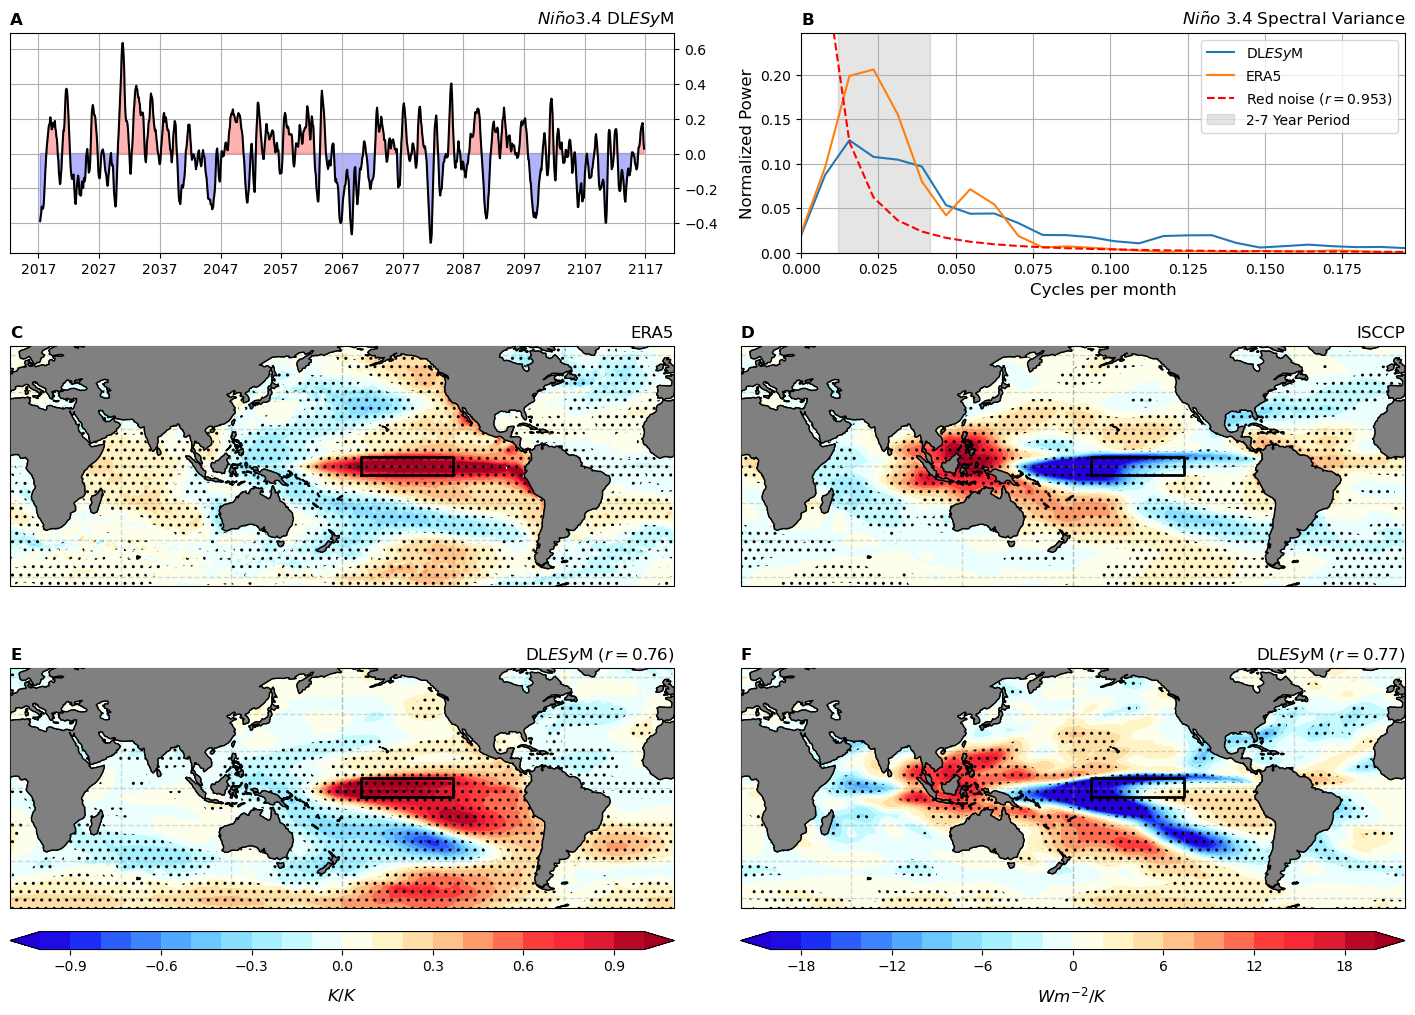

In [32]:
# now load them back in if needed
datasets = [
    xr.open_dataarray(os.path.join(ROOT, "sst_obs_regcoeff_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_obs_regcoeff_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "sst_forecast_regcoeff_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_forecast_regcoeff_nonstd.nc"))
]
pvalues = [
    xr.open_dataarray(os.path.join(ROOT, "sst_obs_pvals_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_obs_pvals_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "sst_forecast_pvals_nonstd.nc")),
    xr.open_dataarray(os.path.join(ROOT, "olr_forecast_pvals_nonstd.nc"))
]

infos = [
    {"save_name": "Figure_10_ENSO_non_normalized", 
     "left_title_1": "C", "right_title_1": "ERA5", "cbar_label": r"$K/K$", "levels": np.arange(-1, 1.1, 0.1)},
    {"left_title_1": "D", "right_title_1": "ISCCP", "cbar_label": r"$Wm^{-2}/K$", "levels": np.arange(-20, 22, 2)},
    {"left_title_1": "E", "right_title_1": r"DL$ESy$M $(r=0.76)$", "cbar_label": r"$K/K$", "levels": np.arange(-1, 1.1, 0.1)},
    {"left_title_1": "F", "right_title_1": r"DL$ESy$M $(r=0.77)$", "cbar_label": r"$Wm^{-2}/K$", "levels": np.arange(-20, 22, 2)},
]

plot_regression_grid(datasets, infos, pvalues_list=pvalues, nrows=2, ncols=2, figsize=(18, 12))